# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


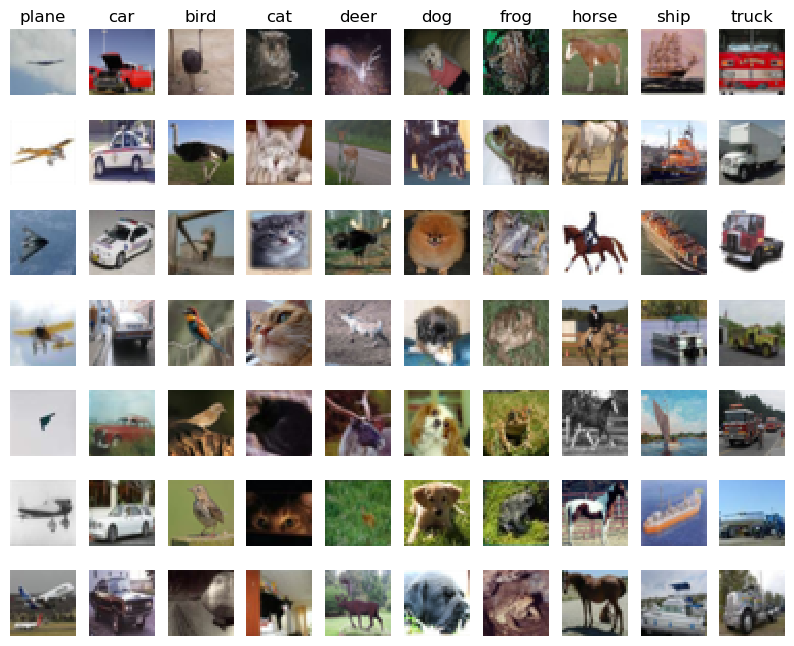

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


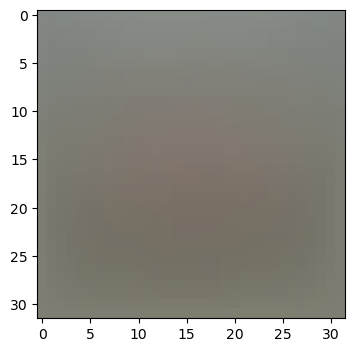

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [7]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [27]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: {}'.format(loss,'#.'))

loss: 9.043316581287481


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you


# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.840062 analytic: 4.840062, relative error: 1.987577e-11
numerical: -30.295759 analytic: -30.295759, relative error: 5.982411e-13
numerical: 16.773540 analytic: 16.773540, relative error: 7.926789e-12
numerical: -2.749404 analytic: -2.749404, relative error: 1.369158e-10
numerical: -1.005652 analytic: -1.005652, relative error: 1.459104e-10
numerical: -0.374207 analytic: -0.374207, relative error: 4.419592e-10
numerical: 28.237161 analytic: 28.237161, relative error: 6.257695e-12
numerical: -18.724501 analytic: -18.724501, relative error: 6.545895e-13
numerical: -36.185509 analytic: -36.185509, relative error: 7.811344e-12
numerical: 19.986624 analytic: 19.986624, relative error: 9.373887e-13
numerical: 2.912284 analytic: 2.912284, relative error: 8.161769e-11
numerical: -18.723491 analytic: -18.708513, relative error: 4.001536e-04
numerical: -3.593769 analytic: -3.587343, relative error: 8.948137e-04
numerical: -3.553049 analytic: -3.561992, relative error: 1.256885e-03
nu

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** 

- The numerical method and analytic method can often mismatch on the SVM loss. The reason is basically that the function "max" provoques an undetermined definition of the derivative at x=0, being SVM_loss = max(0,x). This particular point generates a difference between the numerical and analytical vector, which reflects later on the total value mismatch.

- For example: if we have a dimension that has one score almost similar to 0, or 0 itself. It will cause this mismatch.

In [258]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized,svm_loss_naive

loss1, grad1 = svm_loss_vectorized(W,X_dev,y_dev,0.000005)
loss2,grad2 = svm_loss_naive(W,X_dev,y_dev,0.000005)

In [259]:
grad1

array([[-2.53084190e+01, -5.34998567e+00,  1.39483653e+01, ...,
        -5.33371530e+00, -1.43274324e+01, -3.57683259e+01],
       [-3.49258173e+01, -4.90447549e-01,  8.53679449e+00, ...,
        -9.09673980e+00, -2.54720731e+01, -3.68953241e+01],
       [-5.40947392e+01, -1.89649494e+00,  1.51132786e+01, ...,
        -7.83091225e+00, -4.54501043e+01, -4.48333231e+01],
       ...,
       [-2.35906196e+01,  1.37275025e+01,  6.71888931e+00, ...,
        -1.70407061e+01,  2.04514478e+01, -3.52866155e+00],
       [-3.80919957e+01, -3.56445743e+00,  8.59837171e+00, ...,
         1.52393571e+00,  4.32159828e+00, -3.93829029e+00],
       [ 1.00000006e-02, -1.34000000e-01, -6.60000033e-02, ...,
        -1.50000001e-01, -3.99999885e-03,  2.56000000e-01]])

In [260]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.043317e+00 computed in 0.136672s
Vectorized loss: 9.043317e+00 computed in 0.006005s
difference: 0.000000


In [261]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.136750s
Vectorized loss and gradient: computed in 0.007203s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [312]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.803840
iteration 100 / 1500: loss 289.287550
iteration 200 / 1500: loss 109.124816
iteration 300 / 1500: loss 42.898637
iteration 400 / 1500: loss 18.807079
iteration 500 / 1500: loss 10.630895
iteration 600 / 1500: loss 6.661737
iteration 700 / 1500: loss 6.393069
iteration 800 / 1500: loss 5.842205
iteration 900 / 1500: loss 5.354969
iteration 1000 / 1500: loss 5.109843
iteration 1100 / 1500: loss 4.843993
iteration 1200 / 1500: loss 4.907099
iteration 1300 / 1500: loss 5.688916
iteration 1400 / 1500: loss 4.996730
That took 12.565854s


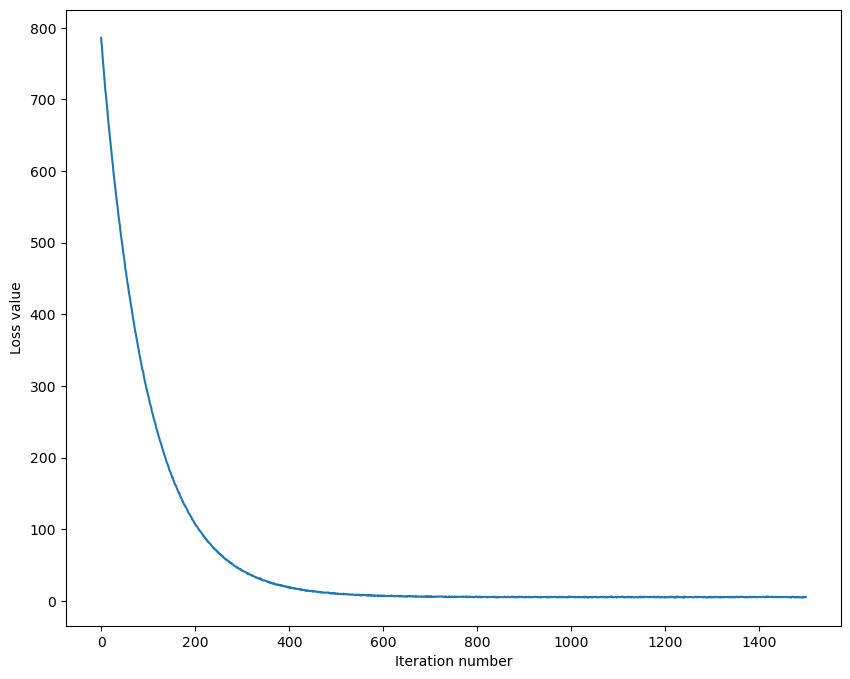

In [278]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

iteration 0 / 1500: loss 5.187592
iteration 100 / 1500: loss 5.670965
iteration 200 / 1500: loss 5.248869
iteration 300 / 1500: loss 5.563009
iteration 400 / 1500: loss 5.052056
iteration 500 / 1500: loss 5.083315
iteration 600 / 1500: loss 5.511763
iteration 700 / 1500: loss 5.440366
iteration 800 / 1500: loss 4.890820
iteration 900 / 1500: loss 5.738786
iteration 1000 / 1500: loss 5.086752
iteration 1100 / 1500: loss 5.283014
iteration 1200 / 1500: loss 5.583792
iteration 1300 / 1500: loss 5.467009
iteration 1400 / 1500: loss 5.549752


In [313]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.373306
validation accuracy: 0.377000


In [318]:
a = {i:val for i,val in sorted(a.items(),key=lambda x:-x[1])}

In [320]:
(1,2)[1]

2

In [336]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [2e-7, 3e-7]
regularization_strengths = [1.5e4, 2.5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for i in np.linspace(learning_rates[0],learning_rates[1],num=4):
    for j in np.linspace(regularization_strengths[0],regularization_strengths[1],num=4):
        
        model = LinearSVM()
        model.train(X_train,y_train,learning_rate=i,reg=j,num_iters=800,verbose=False) #train model
        
        results[(i,j)] = (np.mean(model.predict(X_train)==y_train),np.mean(model.predict(X_val)==y_val)) #Generate and Store Results
        
        if results[(i,j)][1] > best_val:   # Check for possible best new score
            best_val = results[(i,j)][1]
            best_svm = model
        else:
            pass
        
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.000000e-07 reg 1.500000e+04 train accuracy: 0.367224 val accuracy: 0.372000
lr 2.000000e-07 reg 1.833333e+04 train accuracy: 0.365306 val accuracy: 0.362000
lr 2.000000e-07 reg 2.166667e+04 train accuracy: 0.366755 val accuracy: 0.368000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.357469 val accuracy: 0.373000
lr 2.333333e-07 reg 1.500000e+04 train accuracy: 0.373673 val accuracy: 0.388000
lr 2.333333e-07 reg 1.833333e+04 train accuracy: 0.368449 val accuracy: 0.361000
lr 2.333333e-07 reg 2.166667e+04 train accuracy: 0.357490 val accuracy: 0.374000
lr 2.333333e-07 reg 2.500000e+04 train accuracy: 0.361347 val accuracy: 0.363000
lr 2.666667e-07 reg 1.500000e+04 train accuracy: 0.363061 val accuracy: 0.378000
lr 2.666667e-07 reg 1.833333e+04 train accuracy: 0.365735 val accuracy: 0.390000
lr 2.666667e-07 reg 2.166667e+04 train accuracy: 0.362918 val accuracy: 0.363000
lr 2.666667e-07 reg 2.500000e+04 train accuracy: 0.355755 val accuracy: 0.363000
lr 3.000000e-07 reg 1.500000

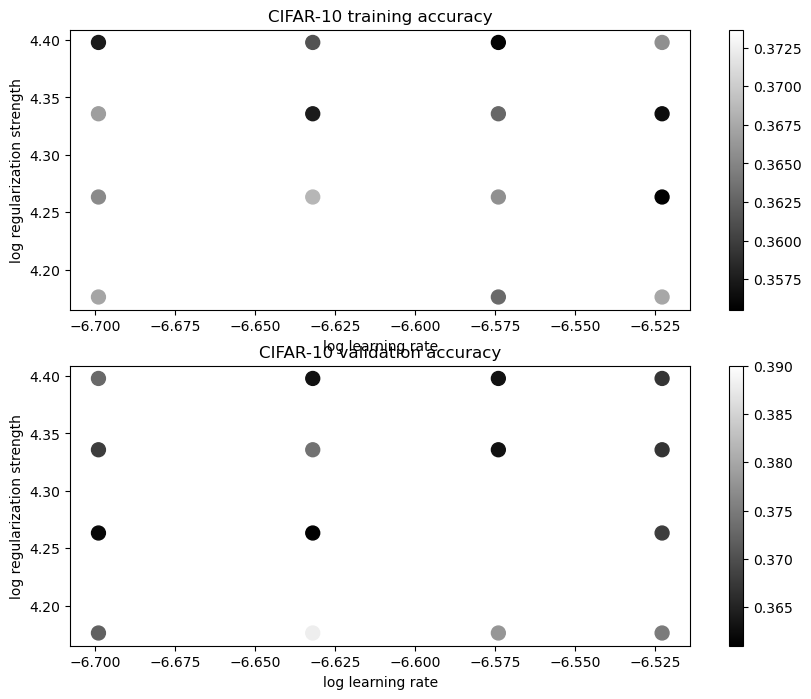

In [337]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [338]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.361000


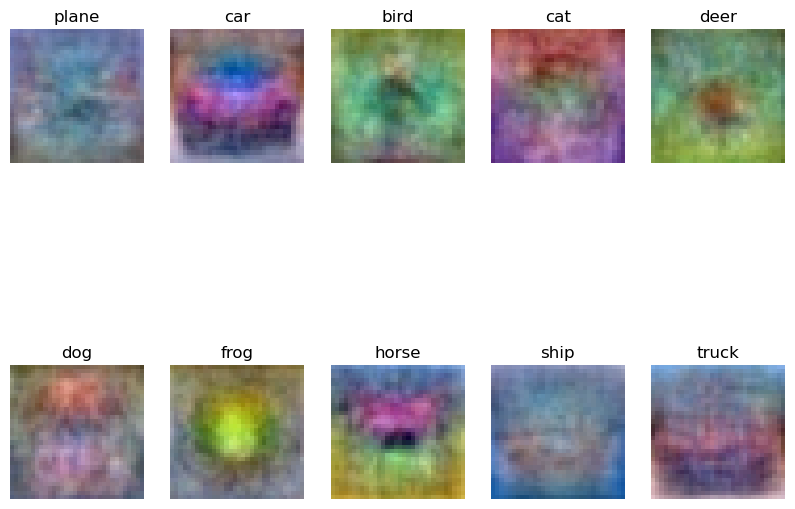

In [339]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 

- The images that we are seeing represent how after training our model with some data, the weight adapts to create a generalization of most of the examples that were given to train. This "general weights" turn out to end representing the shapes and the colors that most of the examples of that specific class have. Lets say for example: that the car weights represent almost a red car observed from ahead, this means that most of the cars images in the dataset are red and are in the same position.

# References:

[[1]](https://mlxai.github.io/2017/01/06/vectorized-implementation-of-svm-loss-and-gradient-update.html).- Vectorized Implementation of SVM Loss and Gradient Update by Nimit Pattanasri.